<a href="https://colab.research.google.com/github/anikch/paddy/blob/main/Code2_Paddy_VGG16_exp3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [41]:
!pip install keras_cv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [42]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from functools import partial
import posixpath
from keras import models, regularizers, layers, optimizers, losses, metrics
import keras_cv
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.utils import plot_model

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
!nvidia-smi

Mon Oct 24 21:15:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    48W / 400W |   9700MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [45]:
colab= '/content/drive/MyDrive'
local= r'G:\My Drive'

code_runtime= colab

In [46]:
tf.__version__

'2.9.2'

In [47]:
file1= 'thesis/dataset/paddy_doctor/train.csv'
inp_file = posixpath.join(code_runtime, file1)

train_table=pd.read_csv(inp_file)
train_table

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45
...,...,...,...,...
10402,107607.jpg,tungro,Zonal,55
10403,107811.jpg,tungro,Zonal,55
10404,108547.jpg,tungro,Zonal,55
10405,110245.jpg,tungro,Zonal,55


In [48]:
labels=list(np.unique(train_table['label']))
labels

['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'bacterial_panicle_blight',
 'blast',
 'brown_spot',
 'dead_heart',
 'downy_mildew',
 'hispa',
 'normal',
 'tungro']

In [49]:
train_dir= 'thesis/dataset/paddy_doctor/train/'
val_dir= 'thesis/dataset/paddy_doctor/val/'
img_size= 224

train_files= posixpath.join(code_runtime, train_dir)
test_files= posixpath.join(code_runtime, val_dir)

train_data= tf.keras.utils.image_dataset_from_directory(train_files,
                                                        labels='inferred',
                                                        label_mode='categorical',
                                                        validation_split=0.2,
                                                        subset="training",
                                                        class_names=labels,
                                                        color_mode='rgb',
                                                        image_size=(img_size, img_size),
                                                        shuffle=True,
                                                        seed= 42,
                                                        batch_size= 16)

val_data= tf.keras.utils.image_dataset_from_directory(train_files,
                                                        labels= 'inferred',
                                                        label_mode='categorical',
                                                        validation_split=0.2,
                                                        subset="validation",
                                                        class_names= labels,
                                                        color_mode='rgb',
                                                        image_size=(img_size, img_size),
                                                        shuffle=True,
                                                        seed= 42,
                                                        batch_size= 16)


test_datagen= ImageDataGenerator()
test_data= test_datagen.flow_from_directory(test_files,
                                            target_size= (img_size, img_size),
                                            batch_size= 16,
                                            shuffle = False, 
                                            class_mode='categorical')

Found 14302 files belonging to 10 classes.
Using 11442 files for training.
Found 14302 files belonging to 10 classes.
Using 2860 files for validation.
Found 1500 images belonging to 10 classes.


In [51]:
class_names = train_data.class_names
print(class_names)

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']


In [52]:
test_data.class_indices

{'bacterial_leaf_blight': 0,
 'bacterial_leaf_streak': 1,
 'bacterial_panicle_blight': 2,
 'blast': 3,
 'brown_spot': 4,
 'dead_heart': 5,
 'downy_mildew': 6,
 'hispa': 7,
 'normal': 8,
 'tungro': 9}

## Augmentation Pipeline

In [56]:
# data augmentation
def augment_train_data(images, labels):
  inputs= {"images": images, "labels": labels}
  layers= keras_cv.layers.RandAugment.get_standard_policy(value_range=(0, 255), geometric= True, magnitude= 0.7, magnitude_stddev= 0.25)
  layers= layers[4:] + [keras_cv.layers.preprocessing.RandomFlip(mode= 'horizontal'),
                    keras_cv.layers.preprocessing.RandomRotation(factor= .1, seed= 42),
                    keras_cv.layers.GridMask(ratio_factor= (.0, .3), rotation_factor= (.0,.1), fill_mode= 'gaussian_noise'), 
                    keras_cv.layers.RandomColorJitter(brightness_factor= .5, contrast_factor= .5, hue_factor= .2, saturation_factor= (.1, .9), value_range= [0, 255])]
  aug_pipeline= keras_cv.layers.RandomAugmentationPipeline(layers= layers, augmentations_per_image= 3)
  outputs= aug_pipeline(inputs)
  print(*layers)
  return outputs['images'], outputs['labels']

In [57]:
AUTOTUNE= tf.data.AUTOTUNE
train_aug_ds= train_data.map(augment_train_data, num_parallel_calls= tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
val_ds= val_data.prefetch(buffer_size= AUTOTUNE)

<keras.layers.preprocessing.image_preprocessing.RandomContrast object at 0x7f3d1f5cdb10> <keras.layers.preprocessing.image_preprocessing.RandomBrightness object at 0x7f3d1f605c50> <keras_cv.layers.preprocessing.random_shear.RandomShear object at 0x7f3d1f578950> <keras_cv.layers.preprocessing.random_shear.RandomShear object at 0x7f3d1f578210> <keras.layers.preprocessing.image_preprocessing.RandomTranslation object at 0x7f3d1f578990> <keras.layers.preprocessing.image_preprocessing.RandomTranslation object at 0x7f3d22d845d0> <keras_cv.layers.preprocessing.random_flip.RandomFlip object at 0x7f3d1f6d8890> <keras_cv.layers.preprocessing.random_rotation.RandomRotation object at 0x7f3d2287db10> <keras_cv.layers.preprocessing.grid_mask.GridMask object at 0x7f3d1f431b10> <keras_cv.layers.preprocessing.random_color_jitter.RandomColorJitter object at 0x7f3d1f42c750>


## VGG16 (Augmentation + Transfer Learning + Fine Tune)

In [58]:
base_model= tf.keras.applications.VGG16(
    include_top= False,
    weights= 'imagenet',
    input_shape=(img_size, img_size, 3),
    pooling= 'max'
)

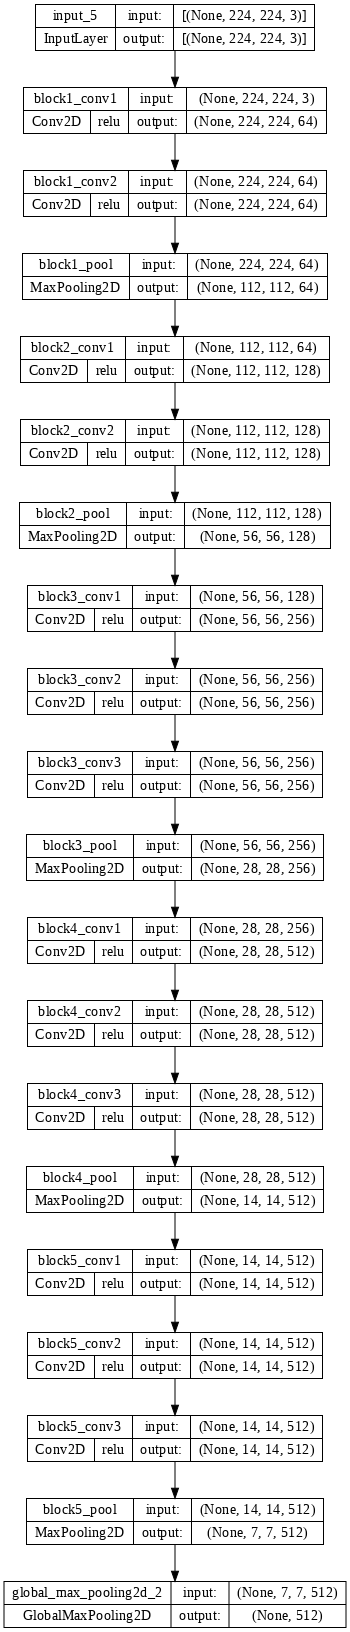

In [59]:
tf.keras.utils.plot_model(
    base_model,
    show_shapes= True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TR",
    expand_nested=False,
    dpi=72,
    layer_range=None,
    show_layer_activations=True,
)

In [60]:
inputs= tf.keras.Input(shape= (img_size, img_size, 3))
preprocess_layer= tf.keras.applications.vgg16.preprocess_input(inputs)
normalization_layer= tf.keras.layers.Rescaling(scale= 1./127.5, offset= -1)(preprocess_layer)
x= base_model(normalization_layer)
x= tf.keras.layers.Dropout(0.25)(x)
outputs= tf.keras.layers.Dense(10, activation= 'softmax')(x)

In [61]:
model= tf.keras.Model(inputs= inputs, outputs= outputs, name= "vgg16_TL_augmentation")

In [62]:
model.summary()

Model: "vgg16_TL_augmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_2   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dropout_2 (Dropout)         (None, 512)     

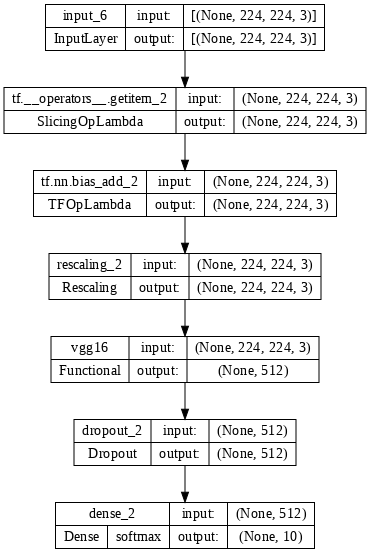

In [63]:
tf.keras.utils.plot_model(
    model,
    show_shapes= True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TR",
    expand_nested=False,
    dpi=72,
    layer_range=None,
    show_layer_activations=True,
)

In [64]:
%%time
n_epochs= 100

filepath= "weights-improvement-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint_callback= ModelCheckpoint(filepath, monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode= 'max')
early_stop_callback= EarlyStopping(monitor='val_accuracy', patience= 10, verbose= False, mode='max', restore_best_weights= True)
callbacks_list=[checkpoint_callback, early_stop_callback]

CPU times: user 164 µs, sys: 0 ns, total: 164 µs
Wall time: 176 µs


In [65]:
optimizer_adam_amsgrad= tf.keras.optimizers.Adam(learning_rate= 1e-4, amsgrad= True)
optimizer_adam= tf.keras.optimizers.Adam(learning_rate= 1e-4, amsgrad= False)
optimizer_sgd= tf.keras.optimizers.SGD(learning_rate= 1e-4, momentum= 0.9)

In [66]:
model.compile(
        optimizer = optimizer_sgd,
        loss = 'categorical_crossentropy', 
        metrics = ['accuracy', tfa.metrics.F1Score(average='macro', num_classes= 10)]
        )

In [67]:
history= model.fit(train_aug_ds,
                  epochs= n_epochs,
                  validation_data= val_ds,
                  callbacks= callbacks_list,
                  verbose= 1)

Epoch 1/100
715/716 [============================>.] - ETA: 0s - loss: 1.8808 - accuracy: 0.3247 - f1_score: 0.3217
Epoch 1: val_accuracy improved from -inf to 0.53846, saving model to weights-improvement-01-0.5385.hdf5
716/716 [==============================] - 29s 40ms/step - loss: 1.8807 - accuracy: 0.3247 - f1_score: 0.3217 - val_loss: 1.3033 - val_accuracy: 0.5385 - val_f1_score: 0.5328
Epoch 2/100
715/716 [============================>.] - ETA: 0s - loss: 1.0964 - accuracy: 0.6175 - f1_score: 0.6131
Epoch 2: val_accuracy improved from 0.53846 to 0.71818, saving model to weights-improvement-02-0.7182.hdf5
716/716 [==============================] - 28s 39ms/step - loss: 1.0971 - accuracy: 0.6174 - f1_score: 0.6130 - val_loss: 0.8769 - val_accuracy: 0.7182 - val_f1_score: 0.7146
Epoch 3/100
714/716 [============================>.] - ETA: 0s - loss: 0.7674 - accuracy: 0.7397 - f1_score: 0.7370
Epoch 3: val_accuracy improved from 0.71818 to 0.77413, saving model to weights-improvement

In [68]:
model.evaluate(test_data, batch_size= 16, return_dict= True)

94/94 [==============================] - 9s 98ms/step - loss: 0.3912 - accuracy: 0.9367 - f1_score: 0.9366


{'loss': 0.3911976218223572,
 'accuracy': 0.9366666674613953,
 'f1_score': 0.9366415739059448}

In [72]:
model_load= tf.keras.models.load_model('/content/weights-improvement-42-0.9413.hdf5')
model_load.evaluate(test_data, batch_size= 16, return_dict= True)

94/94 [==============================] - 10s 99ms/step - loss: 0.3912 - accuracy: 0.9367 - f1_score: 0.9366


{'loss': 0.3911976218223572,
 'accuracy': 0.9366666674613953,
 'f1_score': 0.9366415739059448}

In [73]:
# Generating Confusion Matrix and Classification Report
Y_pred= model.predict_generator(test_data, 1500// 16 + 1)
y_pred= np.argmax(Y_pred, axis= 1)
print('Confusion Matrix')
conf_matrix= confusion_matrix(test_data.classes, y_pred)
conf_mat = np.array2string(conf_matrix)
#print(conf_matrix)
#print("=============================================================================================")
print('Classification Report')
target_names= test_data.class_indices
class_rep_vgg = classification_report(test_data.classes, y_pred, target_names=target_names)
print(class_rep_vgg)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


Confusion Matrix
Classification Report
                          precision    recall  f1-score   support

   bacterial_leaf_blight       0.97      0.87      0.92       150
   bacterial_leaf_streak       0.96      0.93      0.95       150
bacterial_panicle_blight       0.98      0.94      0.96       150
                   blast       0.89      0.95      0.92       150
              brown_spot       0.94      0.91      0.93       150
              dead_heart       0.91      0.99      0.95       150
            downy_mildew       0.98      0.89      0.93       150
                   hispa       0.92      0.95      0.93       150
                  normal       0.94      0.96      0.95       150
                  tungro       0.89      0.96      0.92       150

                accuracy                           0.94      1500
               macro avg       0.94      0.94      0.94      1500
            weighted avg       0.94      0.94      0.94      1500



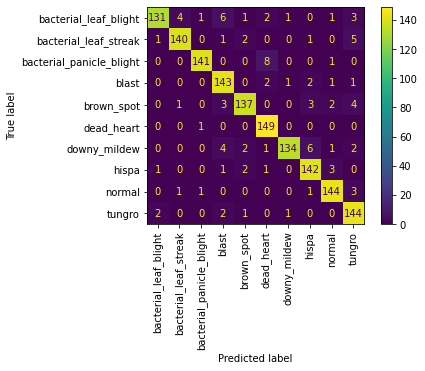

In [74]:
ConfusionMatrixDisplay.from_predictions(test_data.classes, y_pred, display_labels= target_names, xticks_rotation= 'vertical')